In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.insert(0, '/home/ubuntu/opt/fastai')

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn import metrics

In [3]:
PATH = '/home/ubuntu/data/seeding/'

In [4]:
ls {PATH}

models/  sample_submission.csv  test/  tmp/  train/  valid/


# Train the Model

In [5]:
sz = 224
arch=resnext101_64
bs = 58

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [8]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.072213   0.537745   0.820282  
    1      0.661703   0.408139   0.863256                  



[0.40813905, 0.8632557193438212]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 46/60 [00:01<00:00, 40.52it/s, loss=2.68] 


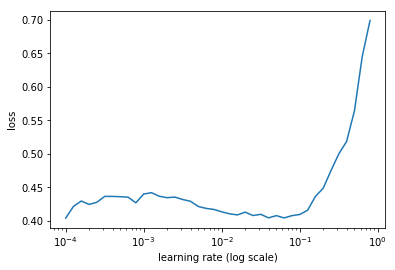

In [9]:
lrf=learn.lr_find()
learn.sched.plot()

In [10]:
lr = 0.05

In [11]:
learn.fit(lr, n_cycle=3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.513317   0.380963   0.862214  
    1      0.461829   0.342932   0.885396                  
    2      0.401366   0.336584   0.876021                  



[0.33658376, 0.8760212421417236]

In [12]:
learn.unfreeze()

In [13]:
learn.fit(lr, n_cycle=3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.396058   0.386277   0.885396  
    1      0.275246   0.302086   0.889828                  
    2      0.314862   0.431148   0.85962                   
    3      0.298735   0.33691    0.892688                  
    4      0.223103   0.323084   0.892953                  
    5      0.168681   0.290951   0.907537                  
    6      0.202934   0.358256   0.883313                  
    7      0.213679   0.368789   0.892177                  
    8      0.201333   0.352741   0.882802                  
    9      0.16531    0.328767   0.893464                  
    10     0.115669   0.295359   0.904677                  
    11     0.091597   0.29193    0.903636                   
    12     0.075419   0.2895     0.90962                    
    13     0.076312   0.290813   0.909886                   



[0.2908128, 0.9098856210708618]

In [14]:
learn.save('12_28_seed_101_first')

In [15]:
lrs=np.array([lr/18,lr/6,lr/2])

In [16]:
learn.fit(lrs, n_cycle=3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.070372   0.29861    0.902328  
    1      0.070468   0.303871   0.906495                   
    2      0.066309   0.299606   0.907802                   
    3      0.069087   0.30655    0.904146                   
    4      0.062478   0.297224   0.915094                   
    5      0.054447   0.299828   0.907802                   
    6      0.05206    0.298432   0.905453                   



[0.2984325, 0.9054534316062928]

In [17]:
learn.save('12_28_seed_101_second')

In [18]:
log_preds, y = learn.TTA()

In [19]:
preds = np.mean(np.exp(log_preds), 0)

In [20]:
metrics.log_loss(y,preds), accuracy(preds,y)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


In [21]:
log_preds_test = learn.predict(is_test = True)

In [22]:
len(log_preds_test)

794

In [23]:
# Get predictions on the test set
# (We can't get accuracy since by definition we don't know)
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [24]:
probs.shape

(794, 12)

In [45]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [46]:
df.head()

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
0,9.611313e-01,9.491045e-08,1.942968e-08,1.217236e-07,2.201338e-07,2.313018e-06,3.886569e-02,3.271662e-09,3.898215e-07,3.272544e-08,1.271840e-08,4.248382e-09
1,7.268005e-03,5.499878e-10,1.700790e-09,2.389928e-12,4.469964e-09,1.010653e-09,9.927328e-01,3.797879e-10,1.598577e-08,1.821191e-09,2.179039e-09,1.627147e-11
2,2.528535e-07,1.663098e-06,4.140295e-05,3.996753e-05,2.566062e-09,1.623201e-07,8.405377e-08,4.564834e-09,4.128837e-07,2.163948e-04,9.996997e-01,2.249265e-09
3,9.380678e-06,3.629664e-05,7.087833e-04,6.749787e-05,1.340173e-03,2.681572e-03,2.790899e-07,2.637341e-03,1.387727e-08,2.866228e-09,1.293690e-09,9.925189e-01
4,2.224294e-05,4.108769e-03,8.988746e-01,5.401365e-02,1.617392e-07,2.022392e-04,5.995990e-04,7.418113e-05,9.480205e-05,4.089060e-02,1.054566e-03,6.430595e-05


In [47]:
# Insert the IDs, but remove the test/ before the file name ([5:-4])
df.insert(0, 'id', [o[5:] for o in data.test_ds.fnames])

In [48]:
df.head()

,id,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
0,4e1190d78.png,9.611313e-01,9.491045e-08,1.942968e-08,1.217236e-07,2.201338e-07,2.313018e-06,3.886569e-02,3.271662e-09,3.898215e-07,3.272544e-08,1.271840e-08,4.248382e-09
1,0ae6668fa.png,7.268005e-03,5.499878e-10,1.700790e-09,2.389928e-12,4.469964e-09,1.010653e-09,9.927328e-01,3.797879e-10,1.598577e-08,1.821191e-09,2.179039e-09,1.627147e-11
2,67ce3eaa6.png,2.528535e-07,1.663098e-06,4.140295e-05,3.996753e-05,2.566062e-09,1.623201e-07,8.405377e-08,4.564834e-09,4.128837e-07,2.163948e-04,9.996997e-01,2.249265e-09
3,5e6a237f2.png,9.380678e-06,3.629664e-05,7.087833e-04,6.749787e-05,1.340173e-03,2.681572e-03,2.790899e-07,2.637341e-03,1.387727e-08,2.866228e-09,1.293690e-09,9.925189e-01
4,506347cfe.png,2.224294e-05,4.108769e-03,8.988746e-01,5.401365e-02,1.617392e-07,2.022392e-04,5.995990e-04,7.418113e-05,9.480205e-05,4.089060e-02,1.054566e-03,6.430595e-05


In [49]:
log_prediction = learn.predict(is_test=True)

In [50]:
log_prediction_test = np.argmax(log_prediction, axis=1)

In [51]:
log_prediction_test

array([ 0,  6, 10, 11,  2,  5,  8,  2,  8,  5,  5, 11,  6,  5,  8,  3,  4,  6,  3, 10, 11,  8,  7,  2,  5,
       11,  2,  8,  6,  6,  4, 10, 10,  1, 11,  6,  3, 10, 11,  6,  6,  6,  2, 10,  6,  6,  4, 10,  2,  8,
        3, 10,  5, 11,  7,  3,  8,  7,  9,  6,  5,  3,  9,  3,  6,  2,  2,  6,  3,  8,  6,  4,  6,  6,  8,
        5,  8, 11,  6,  8,  8, 10,  7,  7,  6,  8, 11, 10,  7,  6,  3,  3, 11,  8,  5,  9,  8,  1, 10,  8,
        5,  5, 10,  6,  1,  1,  3,  5,  5,  7,  0,  9,  3,  3,  5, 11,  3,  6, 10,  5,  4, 11,  1,  2,  4,
        8,  8, 11,  5,  8,  6,  3, 11,  5,  8,  5,  8,  4,  6,  1,  4,  8,  6,  2, 10,  7,  4,  3,  1,  5,
        2,  7,  2,  8,  3,  3,  8,  6,  6, 10,  3,  9, 10,  8, 11,  6,  9,  3, 11,  3,  6,  9, 10,  8,  5,
        6,  8,  9,  3, 11,  5,  7,  2,  8,  6, 10,  2,  3, 10,  2,  0,  6, 11,  3,  6,  2,  6,  3,  2, 10,
        9,  6,  3,  8,  2,  8,  1,  8,  8, 11,  3,  6,  9,  7, 11,  9,  1, 10,  3,  8, 11, 10,  1,  6,  6,
        6, 10, 10,  8, 11,  8,  8, 11

In [52]:
preds_classes = [data.classes[i].replace("_", " ") for i in log_prediction_test]

In [53]:
preds_classes

['Black-grass',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Cleavers',
 'Fat Hen',
 'Scentless Mayweed',
 'Cleavers',
 'Scentless Mayweed',
 'Fat Hen',
 'Fat Hen',
 'Sugar beet',
 'Loose Silky-bent',
 'Fat Hen',
 'Scentless Mayweed',
 'Common Chickweed',
 'Common wheat',
 'Loose Silky-bent',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Scentless Mayweed',
 'Maize',
 'Cleavers',
 'Fat Hen',
 'Sugar beet',
 'Cleavers',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Common wheat',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Charlock',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Cleavers',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Common wheat',
 'Small-flowered Cranesbill',
 'Cleavers',
 'Scentless Mayweed',
 'Common Chickweed',
 'Small-flowered Cranesbi

In [56]:
probas = np.exp(log_prediction)

In [57]:
probas

array([[0.96113, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.00727, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.00004, ..., 0.00022, 0.9997 , 0.     ],
       ...,
       [0.00002, 0.00001, 0.00057, ..., 0.     , 0.     , 0.02116],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.00001, ..., 0.00001, 0.99995, 0.     ]], dtype=float32)

In [58]:
submisson = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})

In [59]:
submisson.head()

,file,species
0,4e1190d78.png,Black-grass
1,0ae6668fa.png,Loose Silky-bent
2,67ce3eaa6.png,Small-flowered Cranesbill
3,5e6a237f2.png,Sugar beet
4,506347cfe.png,Cleavers


In [60]:
submisson.to_csv('kaggle-resnet-submission.csv', index=False)